In [1]:
import os
import cv2
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import Model
from bert4keras.layers import Loss
from bert4keras.optimizers import Adam
from bert4keras.backend import keras, K
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.snippets import sequence_padding, is_string
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder

Using TensorFlow backend.


In [2]:
# bert配置
config_path = 'bert-model/uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = 'bert-model/uncased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = 'bert-model/uncased_L-12_H-768_A-12/vocab.txt'

# 加载并精简词表，建立分词器
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

# 模型配置
maxlen = 64
batch_size = 16


class CrossEntropy(Loss):
    """交叉熵作为loss，并mask掉padding部分
    """
    def compute_loss(self, inputs, mask=None):
        y_true, y_mask, y_pred = inputs
        y_true = y_true[:, 1:]  # 目标token_ids
        y_mask = y_mask[:, 1:]  # segment_ids，刚好指示了要预测的部分
        y_pred = y_pred[:, :-1]  # 预测序列，错开一位
        loss = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss = K.sum(loss * y_mask) / K.sum(y_mask)
        return loss

    
# 条件全连接层
x_in = Input(shape=(2048,), name='image_features')
    
# Bert模型
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='unilm',
    keep_tokens=keep_tokens,  # 只保留keep_tokens中的字，精简原字表
    layer_norm_cond=x_in,
    layer_norm_cond_hidden_size=512,
    layer_norm_cond_hidden_act='swish',
    additional_input_layers=x_in,
)


output = CrossEntropy(2)(model.inputs[0:2] + model.outputs)

model = Model(model.inputs, output)
model.compile(optimizer=Adam(1e-5))
model.summary()


class AutoCaption(AutoRegressiveDecoder):
    """img2seq解码器
    """
    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        token_ids, segment_ids, image = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        return model.predict([token_ids, segment_ids, image])[:, -1]

    def generate(self, inputs, features, topk=1):
        token_ids, segment_ids = tokenizer.encode(inputs, max_length=maxlen)
        output_ids = self.beam_search([token_ids, segment_ids, features], topk)  # 基于beam search
        return tokenizer.decode(output_ids)


autocaption = AutoCaption(
    start_id=None,
    end_id=tokenizer._token_end_id,
    maxlen=maxlen
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     multiple             22417920    Input-Token[0][0]                
                                                                 MLM-Norm[0][0]                   
__________________________________________________________________________________________________
Embedding-S

/home/mist/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output cross_entropy_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cross_entropy_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [3]:
model.load_weights('models/coco2014/base/model_6.weights')

files = os.listdir('data/MSCOCO/annotation/regionfiles/val2014/')
feats = 'data/MSCOCO/annotation/features/val2014/'

colors = [(123,104,238), (64,224,208), (152,251,152), (255,165,0), (255,127,80), (72,118,255),(0,178,238), (139,28,98), (255,185,15)]

image id: COCO_val2014_000000044856.jpg


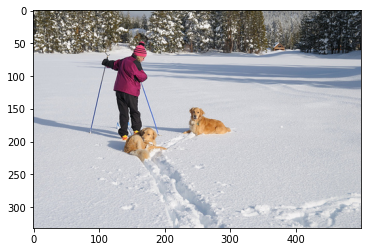

In [145]:
img_id = np.random.choice(files)
print('image id:', img_id.replace('json', 'jpg'))
ann = json.load(open('data/MSCOCO/annotation/regionfiles/val2014/{}'.format(img_id)))
img = 'data/coco2014/val2014/{}'.format(img_id.replace('json', 'jpg'))
feat= np.load(feats+img_id.replace('json', 'npy'), allow_pickle=True)

ann = list(ann.values())
im = cv2.imread(img)
cv2.imwrite('results/im.jpg', im)
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# img_id = 'COCO_val2014_000000571847.jpg'
# print('image id:', img_id)
# ann = json.load(open('data/MSCOCO/annotation/regionfiles/val2014/{}'.format(img_id.replace('jpg', 'json'))))
# img = 'data/coco2014/val2014/{}'.format(img_id)
# feat= np.load(feats+img_id.replace('jpg', 'npy'), allow_pickle=True)

# ann = list(ann.values())
# im = cv2.imread(img)
# cv2.imwrite('results/im.jpg', im)
# plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

caption:  a woman skiing down a snow covered slope next to two brown dogs
woman
snow
slope
dog
predict:  a woman and her dog are walking in the snow


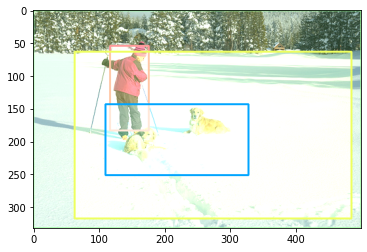

In [146]:
res = {}

print('caption: ', ann[0]['phrase'])
im_0 = cv2.imread(img)
# 把区域圈出来
keywords = ''
for color, ob in enumerate(ann[0]['objects']):
    print(ob['name'])
    keywords += ob['name'] + ' '
    zeros = np.zeros((im_0.shape), dtype=np.uint8)
    zeros_mask = cv2.rectangle(zeros, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], thickness=-1)
    im_0 = cv2.addWeighted(im_0, 1, zeros_mask, 0.2, 0)
    cv2.rectangle(im_0, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], 2)
    
res['caption'] = ann[0]['phrase']
res['predict'] = autocaption.generate('', feat[0]['image_features'])
res['keywords'] = keywords

print('predict: ', res['predict'])
plt.imshow(cv2.cvtColor(im_0,cv2.COLOR_BGR2RGB))
cv2.imwrite('results/im_0.jpg', im_0)

with open('results/im_0.json', "w") as f:
    json.dump(res, f)

caption:  a person is skating down a railing outside
person
railing
predict:  a man on a skateboard doing a trick


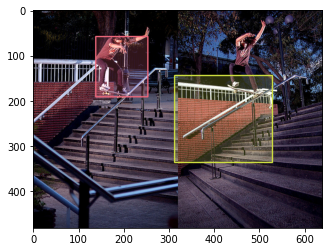

In [6]:
print('caption: ', ann[1]['phrase'])
im_1 = cv2.imread(img)
# 把区域圈出来
keywords = ''
for color, ob in enumerate(ann[1]['objects']):
    print(ob['name'])
    keywords += ob['name'] + ' '
    zeros = np.zeros((im_1.shape), dtype=np.uint8)
    zeros_mask = cv2.rectangle(zeros, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], thickness=-1)
    im_1 = cv2.addWeighted(im_1, 1, zeros_mask, 0.2, 0)
    cv2.rectangle(im_1, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], 2)
    
res['caption'] = ann[1]['phrase']
res['predict'] = autocaption.generate('', feat[0]['image_features'])
res['keywords'] = keywords
    
print('predict: ', res['predict'])
plt.imshow(cv2.cvtColor(im_1,cv2.COLOR_BGR2RGB))
cv2.imwrite('results/im_1.jpg', im_1)

with open('results/im_1.json', "w") as f:
    json.dump(res, f)

caption:  two pictures next to each other of a skate boarder going down a bannister
boarder
bannister
predict:  a man on a skateboard doing a trick


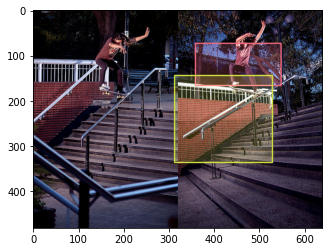

In [7]:
print('caption: ', ann[2]['phrase'])
im_2 = cv2.imread(img)
# 把区域圈出来
keywords = ''
for color, ob in enumerate(ann[2]['objects']):
    print(ob['name'])
    keywords += ob['name'] + ' '
    zeros = np.zeros((im_2.shape), dtype=np.uint8)
    zeros_mask = cv2.rectangle(zeros, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], thickness=-1)
    im_2 = cv2.addWeighted(im_2, 1, zeros_mask, 0.2, 0)
    cv2.rectangle(im_2, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], 2)
    
res['caption'] = ann[2]['phrase']
res['predict'] = autocaption.generate('', feat[0]['image_features'])
res['keywords'] = keywords
    
print('predict: ', res['predict'])
plt.imshow(cv2.cvtColor(im_2,cv2.COLOR_BGR2RGB))
cv2.imwrite('results/im_2.jpg', im_2)

with open('results/im_2.json', "w") as f:
    json.dump(res, f)

caption:  two pictures show a skateboarder riding down the hand rail of some stairs
skateboarder
rail
stair
predict:  a man on a skateboard doing a trick


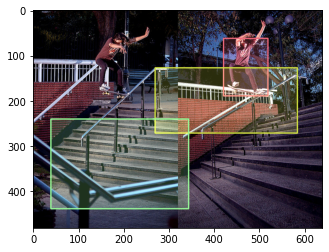

In [8]:
print('caption: ', ann[3]['phrase'])
im_3 = cv2.imread(img)
# 把区域圈出来
keywords = ''
for color, ob in enumerate(ann[3]['objects']):
    print(ob['name'])
    keywords += ob['name'] + ' '
    zeros = np.zeros((im_3.shape), dtype=np.uint8)
    zeros_mask = cv2.rectangle(zeros, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], thickness=-1)
    im_3 = cv2.addWeighted(im_3, 1, zeros_mask, 0.2, 0)
    cv2.rectangle(im_3, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], 2)
    
res['caption'] = ann[3]['phrase']
res['predict'] = autocaption.generate('', feat[0]['image_features'])
res['keywords'] = keywords
    
print('predict: ', res['predict'])
plt.imshow(cv2.cvtColor(im_3,cv2.COLOR_BGR2RGB))
cv2.imwrite('results/im_3.jpg', im_3)

with open('results/im_3.json', "w") as f:
    json.dump(res, f)

In [255]:
print('caption: ', ann[4]['phrase'])
im_4 = cv2.imread(img)
# 把区域圈出来
keywords = ''
for color, ob in enumerate(ann[4]['objects']):
    print(ob['name'])
    keywords += ob['name'] + ' '
    zeros = np.zeros((im_4.shape), dtype=np.uint8)
    zeros_mask = cv2.rectangle(zeros, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], thickness=-1)
    im_4 = cv2.addWeighted(im_4, 1, zeros_mask, 0.2, 0)
    cv2.rectangle(im_4, (ob['x'], ob['y']), (ob['x']+ob['w'], ob['y']+ob['h']), colors[color], 2)
    
res['caption'] = ann[4]['phrase']
res['predict'] = autocaption.generate('', feat[0]['image_features'])
res['keywords'] = keywords
    
print('predict: ', res['predict'])
plt.imshow(cv2.cvtColor(im_4,cv2.COLOR_BGR2RGB))
cv2.imwrite('results/im_4.jpg', im_4)

with open('results/im_4.json', "w") as f:
    json.dump(res, f)

IndexError: list index out of range